<a href="https://colab.research.google.com/github/isaacd68/MAT421/blob/main/20_1%2C20_2%2C20_3%2C20_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finite Difference Approximating Derivatives**

In [1]:
from __future__ import print_function
from sympy import *
x, x0, h = symbols('x, x_i, h')
Fi, Fim1, Fip1 = symbols('F_{i}, F_{i-1}, F_{i+1}')
n = 3 # there are the coefficients c_0=Fi,  c_1=dF/h,  c_2=d**2F/h**2
c = symbols('c:3')
# define a polynomial of degree n
def P(x, x0, c, n):
   return sum( ((1/factorial(i))*c[i] * (x-x0)**i for i in range(n)) )
# now we make a matrix consisting of the coefficients
# of the c_i in the nth degree polynomial P
# coefficients of c_i evaluated at x_i
m11 = P(x0 , x0, c, n).diff(c[0])
m12 = P(x0 , x0, c, n).diff(c[1])
m13 = P(x0 , x0, c, n).diff(c[2])
# coefficients of c_i evaluated at x_i - h
m21 = P(x0-h, x0, c, n).diff(c[0])
m22 = P(x0-h, x0, c, n).diff(c[1])
m23 = P(x0-h, x0, c, n).diff(c[2])
# coefficients of c_i evaluated at x_i + h
m31 = P(x0+h, x0, c, n).diff(c[0])
m32 = P(x0+h, x0, c, n).diff(c[1])
m33 = P(x0+h, x0, c, n).diff(c[2])
# matrix of the coefficients is 3x3 in this case
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

Now that we have the matrix of coefficients we next form the right-hand-side and solve by inverting M:

In [3]:
# matrix of the function values...actually a vector of right hand sides
R = Matrix([[Fi], [Fim1], [Fip1]])
# matrix form of the three equations for the c_i is M*X = R
# solution directly inverting the 3x3 matrix M:
X =  M.inv() * R
# note that all three coefficients make up the solution
# the first derivative is coefficient c_1 which is X[1].
print("The second-order accurate approximation for the first derivative is: ")

print(together(X[1]))

The second-order accurate approximation for the first derivative is: 
(F_{i+1} - F_{i-1})/(2*h)


# Approximating of Higher Order Derivatives

In [4]:
def derivative(f,a,method='central',h=0.01):
    '''Compute the difference formula for f'(a) with step size h.

    Parameters
    ----------
    f : function
        Vectorized function of one variable
    a : number
        Compute derivative at x = a
    method : string
        Difference formula: 'forward', 'backward' or 'central'
    h : number
        Step size in difference formula

    Returns
    -------
    float
        Difference formula:
            central: f(a+h) - f(a-h))/2h
            forward: f(a+h) - f(a))/h
            backward: f(a) - f(a-h))/h            
    '''
    if method == 'central':
        return (f(a + h) - f(a - h))/(2*h)
    elif method == 'forward':
        return (f(a + h) - f(a))/h
    elif method == 'backward':
        return (f(a) - f(a - h))/h
    else:
        raise ValueError("Method must be 'central', 'forward' or 'backward'.")

for sin(0)=0 we compute

In [6]:
import numpy as np
derivative(np.cos,0)

0.0

In [7]:
derivative(np.cos,0,method='forward',h=1e-8)

0.0

for $e^0=1$ we compute

In [8]:
derivative(np.exp,0,h=0.0001)

1.0000000016668897

In [9]:
derivative(np.exp,0,method='backward',h=0.0001)

0.9999500016666385

Notice that our function can take an array of inputs for $a$ and return the derivatives for each $a$ value. For example, we can plot the derivative of $sin(x)$:

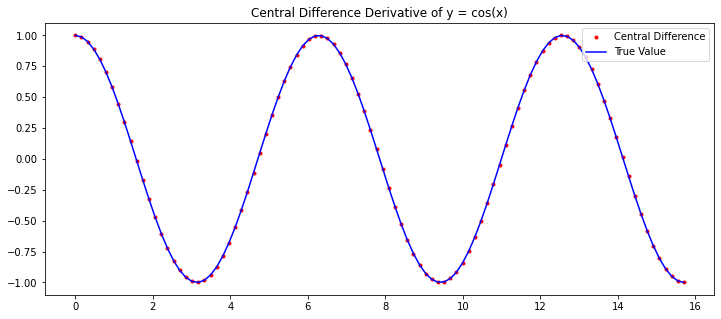

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
x = np.linspace(0,5*np.pi,100)
dydx = derivative(np.sin,x)

dYdx = np.cos(x)

plt.figure(figsize=(12,5))
plt.plot(x,dydx,'r.',label='Central Difference')
plt.plot(x,dYdx,'b',label='True Value')

plt.title('Central Difference Derivative of y = cos(x)')
plt.legend(loc='best')
plt.show()

# Numerical Differentiation with Noise

In [25]:
# Setup
%load_ext autoreload
%matplotlib nbagg
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
from PIL import Image # On charge Python Image Library
from matplotlib import pyplot as plt # On charge pyplot (un sous module de Matplotlib) et on le renomme plt
from matplotlib import cm
from scipy import ndimage
from scipy import interpolate
from scipy import signal

from geopy.distance import great_circle, vincenty

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
class ElevMap:
    """
    This class manipulates elavation map comming from https://earthexplorer.usgs.gov/.
    The supported format is : digital  elevation / SRMT 1 arc-seconde global
    Where 1pix = 1 arc second
    """
    def __init__(self, file_name):
        self.file_name = file_name
        self.read_elevation_from_file()


    #https://librenepal.com/article/reading-srtm-data-with-python/
    def read_elevation_from_file(self):
        SAMPLES = 3601 # Change this to 3601 for SRTM1
        with open(self.file_name, 'rb') as hgt_data:
            # Each data is 16bit signed integer(i2) - big endian(>)
            elevations = np.fromfile(hgt_data, np.dtype('i2'), SAMPLES*SAMPLES).reshape((SAMPLES, SAMPLES))

        self.elevations = elevations[4:,4:].astype(np.float64)

        # Creat the grid of coordonee associated with the elevation map
        Nx,Ny = self.elevations.shape
        cor=self.file_name.split("_")[-2]
        N=float(cor[1:3])
        E=float(cor[4:])
        x = np.linspace(E, E + 1, Nx)
        y = np.linspace(N + 1, N, Ny)
        self.Xg, self.Yg = np.meshgrid(x, y)

        self.aspect = great_circle((self.Yg[0,0] ,self.Xg[0,0]) , (self.Yg[-1,0] ,self.Xg[-1,0])).km / great_circle((self.Yg[0,0] ,self.Xg[0,0]) , (self.Yg[0,-1] ,self.Xg[0,-1])).km


    def plot(self,ax):
        cs = ax.contourf(self.Xg, self.Yg, self.elevations , vmin=0, vmax=4808)
        ax.set_aspect(aspect=self.aspect)
        return cs


    def plot_track(self,ax, df):
        mask = np.ones(self.Xg.shape)

        large = .03
        mask[np.where(self.Xg  < df.long.min() - large  )]=np.nan
        mask[np.where(self.Xg  > df.long.max() + large )]=np.nan

        mask[np.where(self.Yg < df.lat.min() - large )]=np.nan
        mask[np.where(self.Yg > df.lat.max() + large )]=np.nan

        cs = ax.contourf(self.Xg , self.Yg , self.elevations*mask )
        plt.plot(df.long,df.lat,'r',label = "path")
        ax.set_aspect(aspect=self.aspect)

        ax.set_xlim(df.long.min() - large  , df.long.max() + large )
        ax.set_ylim(df.lat.min()  - large  , df.lat.max()  + large )

        return cs

In [27]:
site_coord=np.array([[6.865133,45.832634],[ 6.157845,45.919490],[6.389560,45.663787], [6.864840,45.916684],[6.633973,45.935047],[6.672323,45.200746],[ 6.425097, 45.904318]])
site_name = ["Mont Blanc", "Polytech", "Albertville","Chamonix",'Sallanches', "Modane","La Cluzas"]

In [33]:
df = pd.DataFrame([] , index = [], columns = ['time','seconde', 'lat', 'long','elevation','dist'])

In [34]:
df.head(30)

,time,seconde,lat,long,elevation,dist


In [40]:
fig = plt.figure()
plt.plot(df.dist,df.elevation,'b',label = "Elevation")
plt.ylabel("Distance [$m$]")
plt.xlabel("Elevation [$m$]")
plt.grid()
plt.legend()
plt.show()
<IPython.core.display.Javascript object>

SyntaxError: ignored

In [42]:
fig = plt.figure()
plt.plot(df.seconde/60,df.dist,'b',label = "path")
plt.xlabel("temps [$min$]")
plt.ylabel("Distance [$m$]")
plt.grid()
plt.legend()
plt.show()
<IPython.core.display.Javascript object>

SyntaxError: ignored

In [43]:
vit = np.diff(df.dist)/np.diff(df.seconde)
vit = vit * 3.6 # m/s to km/h

In [44]:
fig = plt.figure()
plt.plot(df.seconde[:-1]/60,vit,'+b')
plt.xlabel("temps [$min$]")
plt.ylabel("Velocity [$km/h$]")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>